# Running Cortical Stimulation on ECoG and SEEG Patients

1/24/19: For EMBC, we will apply a cortical stimulation paradigm that involves estimation of A matrices, and then applying impulse responses for each channel and then measuring some metric to determine the: i) onset region and ii) propagation regions.



In [2]:
# import basic functionality / libs
import sys
import os
import numpy as np
import pandas as pd
import json
import scipy

from sklearn.preprocessing import MinMaxScaler, StandardScaler

sys.path.append('../../')
from eztrack.edp.loaders.patient.subjectresultsloader import SubjectResultsLoader
from eztrack.edp.loaders.dataset.result.resultloader import ResultLoader
from eztrack.edp.utils.utils import writejsonfile

from eztrack.edv.plot_fragility_heatmap import PlotFragilityHeatmap
from eztrack.edv.baseplot import BasePlotter

%matplotlib inline
# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Import magic commands for jupyter notebook 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def create_impulse_maps(impulseresponses, indslist, onsetwin, offsetwin):
    # create a dictionary of all the impulse maps
    impulse_maps = dict()

    scaler = StandardScaler()
    scaler = MinMaxScaler()
    
    # go through each of the onset contacts and create impulse response maps
    for i, ind in enumerate(indslist):
        # propagation map
        propagation_map = []
        # ranked order of response magnitudes
        rankorder_map = []

        # trim out the impulseresponses
        numwins_per_sec = 10
        numsecs_offset = 15
        buffer = numwins_per_sec * numsecs_offset
        trimmed_impulse_responses = impulseresponses[onsetwin-buffer:offsetwin+buffer,
                                                     ...]
        newonsetwin = buffer
        newoffsetwin = len(trimmed_impulse_responses) - buffer

        # loop through time axis for each matrix of responses from this channel
        for j in range(len(trimmed_impulse_responses)):
            currimpulse = trimmed_impulse_responses[j]

            # get the corresponding l2 norm responses from this channel
            l2_norm_responses = currimpulse[ind,:]
            # apply normalization to the normed responses
            l2_norm_responses = scaler.fit_transform(l2_norm_responses[:,np.newaxis])
            
            # print a debug statement on the data shapes
            if i == 0 and j == 0:
                plt.plot(l2_norm_responses, 'k*')
                print("ImpResponse shape, current response shape, l2norm vec shape: ", 
                      trimmed_impulse_responses.shape, currimpulse.shape, l2_norm_responses.shape)

            # rank order them
            sorted_inds = np.argsort(l2_norm_responses, axis=-1, kind='mergesort')

            # append each node's response to the propagation map
            propagation_map.append(l2_norm_responses.squeeze())
            # store the rank order mapping
            rankorder_map.append(sorted_inds.squeeze())

        propagation_map = np.array(propagation_map).T
        # store the impulse map
        impulse_maps[chanlabels[ind]] = propagation_map
        
    return impulse_maps

In [49]:
def reject_outliers(data, m=1.5):
    ceil_val = np.mean(data.ravel())*m
    outlier_val = np.mean(data) + np.std(data)*m
    
    inds = np.where(data > outlier_val)
    newdata = data.copy()
    newdata[inds] = ceil_val
    return newdata

def reject_outliers_median(data, m=5):
    ceil_val = np.median(data.ravel())*m
    outlier_val = np.median(data) + np.std(data)*m
    
    inds = np.where(data > outlier_val)
    newdata = data.copy()
    newdata[inds] = ceil_val
    return newdata


def plot_map(mat, labels, onsetchans, onsetwin, offsetwin, figdir, outputfigurename,
            titlestr=""):
    if titlestr == "":
        titlestr = "Impulse Response Map iEEG"
        
    outputfigurename = os.path.splitext(outputfigurename)[0]

    plotter = PlotFragilityHeatmap(figdir)

    vertlines = [onsetwin, offsetwin]
    if onsetwin is None:
        vertlines = []
    elif offsetwin is None:
        vertlines = [onsetwin]

#     sns.set(font_scale=1.25)
    fig, ax = plotter.plot_fragility_map(mat, labels, onsetchans, spreadchans=[],
                                         vertlines=vertlines, markercolors=['g', 'b'],
                               titlestr=titlestr, #vertlabels=['onset', 'offset'],
                               figure_name="{}".format(outputfigurename), 
                               cbarlabel="L2-Norm of Impulse Response")
    return fig,ax

# Setup Data Directories

In [5]:
center = 'nih'
reference = 'monopolar'
modality = 'ieeg'
patid = 'pt1'

basedir = '/Users/adam2392/Downloads/output_new/fragility/'
# basedir = "/home/adam2392/hdd/data/processed/output_new/fragility/"
resultsdir = os.path.join(basedir, '{reference}/{modality}/'.
                          format(reference=reference,
                                modality=modality), 
                          center)

print(resultsdir)

/Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih


In [6]:
patientloader = SubjectResultsLoader(subjid=patid,
                            preload=True,
                            datatype='frag',
                            root_dir=resultsdir)

print("Finished loading in data for this patient")

Found 6 jsonfilepaths for pt1
Loading results data from:  /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_ii_1_fragmodel.npz
Onset index and offsetindex None [404875 405124]
None [404875 405124]
Found offsetwin:  None
Loading results data from:  /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_ii_2_fragmodel.npz


../../eztrack/edp/loaders/patient/subjectresultsloader.py:63: UserWarning: Result model onsetwin == offsetwin in /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_ii_1_frag.json
  "Result model onsetwin == offsetwin in {}".format(jsonfilepath))


Onset index and offsetindex None [413875 414124]
None [413875 414124]
Found offsetwin:  None
Loading results data from:  /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_sz_2_fragmodel.npz


../../eztrack/edp/loaders/patient/subjectresultsloader.py:63: UserWarning: Result model onsetwin == offsetwin in /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_ii_2_frag.json
  "Result model onsetwin == offsetwin in {}".format(jsonfilepath))


Loading results data from:  /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_sz_3_fragmodel.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_sz_4_fragmodel.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/fragility/monopolar/ieeg/nih/pt1_sz_6_fragmodel.npz
Finished loading in data for this patient


In [7]:
print("These are all the datasets: \n", patientloader.get_results())

These are all the datasets: 
 [pt1 sz_2 Fragility Model (86, 2151), pt1 sz_3 Fragility Model (86, 2841), pt1 sz_4 Fragility Model (86, 2967), pt1 sz_6 Fragility Model (86, 2488)]


In [8]:
dataset = patientloader.get_results()[0]

print(dataset)

pt1 sz_2 Fragility Model (86, 2151)


In [9]:
ltvdataset = dataset.ltvmodel
ltvmat = ltvdataset.get_data()

print(ltvdataset)

ltvmat = np.rollaxis(ltvmat, 2,0)
print(ltvmat.shape)

pt1 sz_2 LTV Model (86, 86, 2151)
(2151, 86, 86)


In [10]:
metadata = dataset.get_metadata()

print(metadata['ez_hypo_contacts'], metadata['seizure_semiology'], metadata['ablated_contacts'])

['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2'] [['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2'], ['att3', 'ast1', 'ast2'], ['att4', 'att5', 'att6', 'slt2', 'slt3', 'slt4', 'mlt2', 'mlt3', 'mlt4', 'g8', 'g16']] []


In [11]:
# get the fragility matrix
fragmat = dataset.get_data()

# get the corresponding channels labels
chanlabels = dataset.chanlabels

# get ieeg ez
cezcontacts = dataset.cezcontacts

# get indices of ieeg cez
ieegcezinds = dataset.cezinds

print("Summary of Data: ")
print(fragmat.shape, len(chanlabels))
print(cezcontacts, ieegcezinds)

Summary of Data: 
(86, 2151) 86
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2'] [32, 33, 54, 55, 56, 57, 58, 59, 60, 61]


# Setup Impulse Model Framework

In [113]:
impulsemodel = ImpulseModel()

NameError: name 'ImpulseModel' is not defined

In [ ]:
l2norm_responses = impulsemodel.run(ltvmat, stabilize=True)


In [ ]:
print(len(l2norm_responses), 
      l2norm_responses[0][0].shape,
      len(l2norm_responses[0]))

In [ ]:
outputfilepath = os.path.join("./", "{}_impulse_responses.npz".format(patid + dataset.dataset_id))
jsonfilepath = outputfilepath.replace('.npz', '.json')

In [ ]:
# store all the impulse responses locally
pat_impulse_results = impulsemodel.all_impulse_responses

print(len(pat_impulse_results), pat_impulse_results[0].shape)
np.savez_compressed(outputfilepath, 
                    impulse_results=l2norm_responses)


In [ ]:

metadata['resultfilename'] = os.path.basename(outputfilepath)
metadata['impulse_length'] = impulsemodel.N
metadata['impulse_metric'] = 'l2norm'

writejsonfile(metadata, jsonfilepath, overwrite=True)

In [ ]:
print("Done?")

# Run Propagation Prediction Rank-Sorted Likelihood Algorithm

In [12]:
figdir = "/Users/adam2392/Documents/figures/all_fragility_maps/{}".format(patid)
# figdir = "/home/adam2392/Downloads/figures/impulse_responses/{}".format(patid)

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [13]:
modality = 'ieeg'
# modality = 'scalp'
reference = "common_avg"
reference = "monopolar"
center = 'nih'
modelname = "impulse"

datadir = f"/Users/adam2392/Downloads/output_new/{modelname}/{reference}/{modality}/{center}"

allfiles = os.listdir(datadir)
print(len(allfiles))


91


In [51]:
datasetloader = ResultLoader(
                            preload=True,
                            datatype='impulse',
                            results_dir=datadir)
jsonfilepaths = datasetloader.jsonfilepaths

patid = 'pt6'
datasetid = 'sz_4'
patjsonfile = [f for f in jsonfilepaths if patid in f if datasetid in f]
print(jsonfilepaths)
print("Finished loading in data for this patient")

['pt1_sz_2_impulse_responses.json', 'pt1_sz_3_impulse_responses.json', 'pt1_sz_4_impulse_responses.json', 'pt1_sz_6_impulse_responses.json', 'pt1sz_3_impulse_responses.json', 'pt2_sz_1_impulse_responses.json', 'pt2_sz_3_impulse_responses.json', 'pt2_sz_4_impulse_responses.json', 'pt3_sz_2_impulse_responses.json', 'pt3_sz_4_impulse_responses.json', 'pt6_sz_3_impulse_responses.json', 'pt6_sz_4_impulse_responses.json', 'pt6_sz_5_impulse_responses.json', 'pt6sz_3_impulse_responses.json', 'pt7_sz_19_impulse_responses.json', 'pt7_sz_21_impulse_responses.json', 'pt7_sz_22_impulse_responses.json', 'pt8_sz_1_impulse_responses.json', 'pt8_sz_2_impulse_responses.json', 'pt8_sz_3_impulse_responses.json', 'pt10_sz_1_impulse_responses.json', 'pt10_sz_2_impulse_responses.json', 'pt10_sz_3_impulse_responses.json', 'pt11_sz_1_impulse_responses.json', 'pt11_sz_2_impulse_responses.json', 'pt11_sz_3_impulse_responses.json', 'pt11_sz_4_impulse_responses.json', 'pt12_sz_1_impulse_responses.json', 'pt12_sz_2

In [52]:
impulsemodel = datasetloader.loadpipeline(jsonfilepath = patjsonfile[0])

Loading results data from:  /Users/adam2392/Downloads/output_new/impulse/monopolar/ieeg/nih/pt6_sz_4_impulse_responses.npz


In [53]:
impulsemodel = datasetloader.result
impulseresponses = impulsemodel.get_data()
print(impulseresponses.shape)

(3297, 81, 81)


In [54]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

print(impulseresponses.shape)
# print(currimpulse.shape)
# print(len(trimmed_impulse_responses))

(3297, 81, 81)


Onset index and offsetindex 150737.0 [412000 412249]
275379.0 [412000 412249]
Found offsetwin:  [2202]
(81, 1598)


../../eztrack/edv/baseplot.py:134: UserWarning: Noninteractive matplotlib backend! No highlighting functionality in plots!
  "Noninteractive matplotlib backend! No highlighting functionality in plots!")


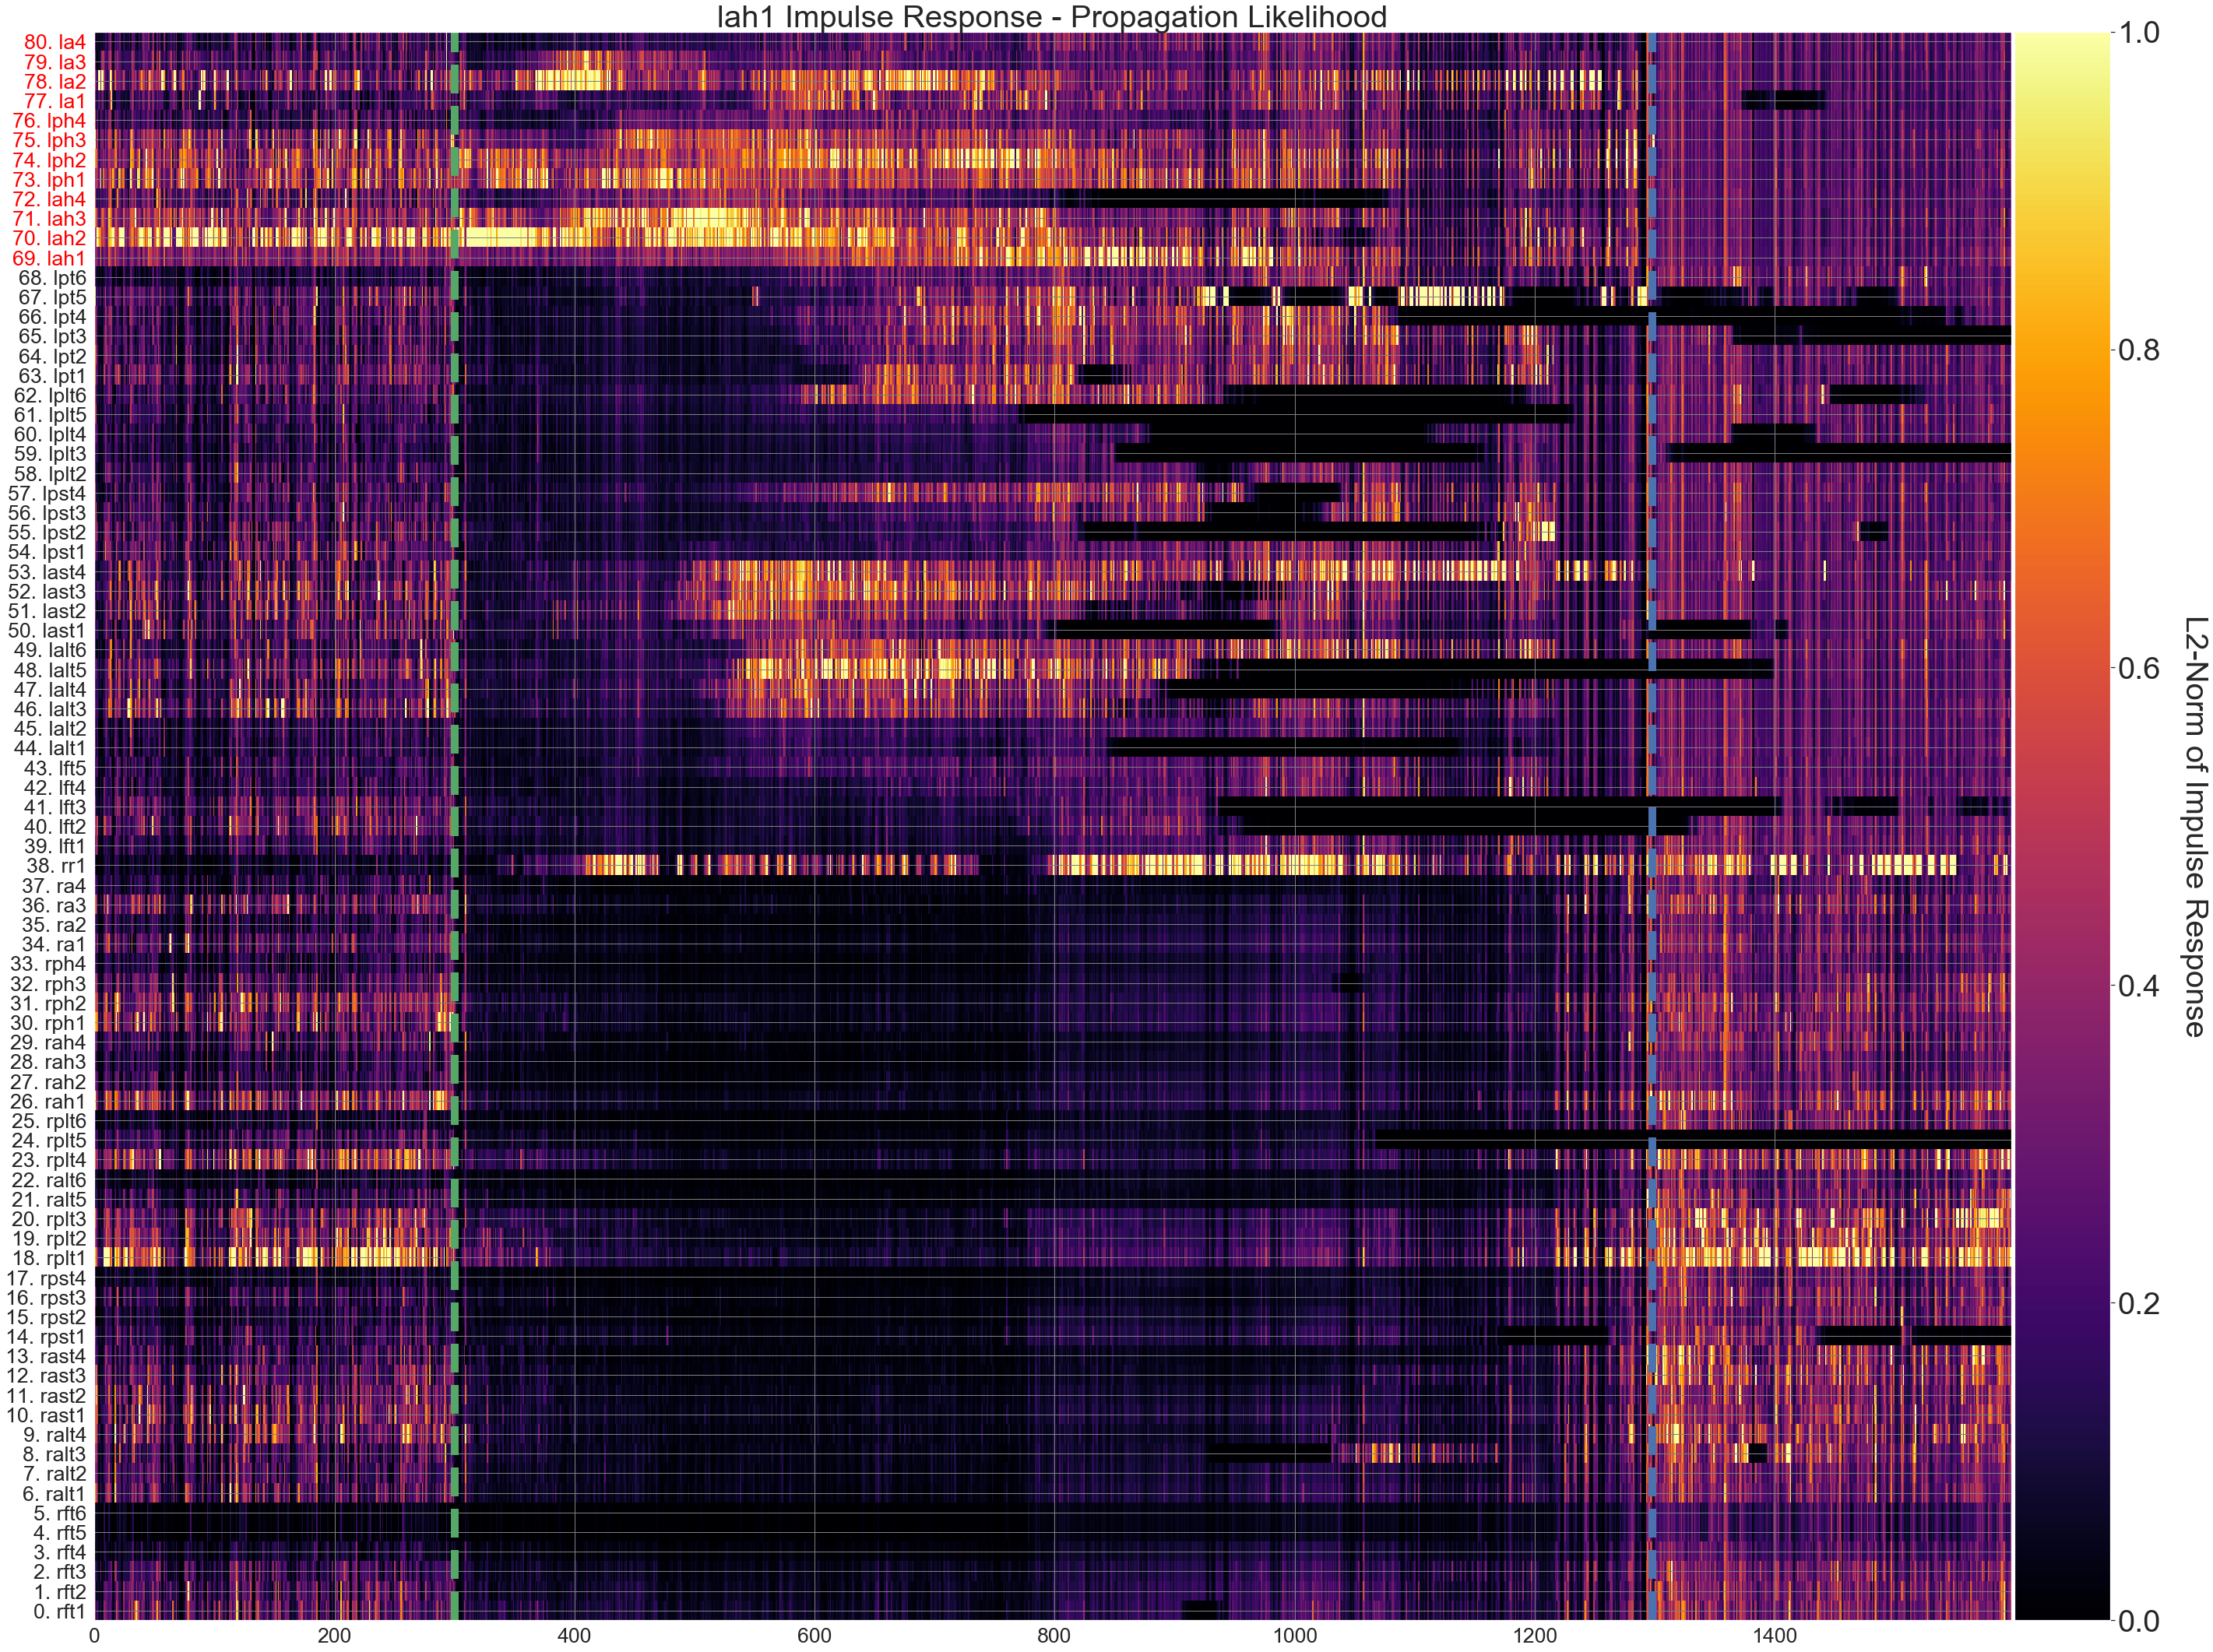

In [55]:
# initialize metadata necessary for plotting
chanlabels = impulsemodel.chanlabels
onsetwin = impulsemodel.onsetwin
offsetwin = impulsemodel.offsetwin
ieegcezinds = impulsemodel.cezinds
oezinds = impulsemodel.oezinds
cezcontacts = impulsemodel.cezcontacts

ieegcezinds = ieegcezinds + oezinds[0:3]
# go through each of the onset contacts and create impulse response maps
for i, cezind in enumerate(ieegcezinds):
    # propagation map
    propagation_map = []
    rankorder_map = []
    
    # trim out the impulseresponses in time
    trimmed_impulse_responses = impulseresponses[onsetwin-10*30:offsetwin+10*30,...]
    newonsetwin = 10*30
    newoffsetwin = len(trimmed_impulse_responses) - 10*30
    
    # loop through each channel
    for t in range(len(trimmed_impulse_responses)):
        # get the corresponding l2 norm responses from this channel
        l2_norm_responses = trimmed_impulse_responses[t, cezind, :]
        # apply normalization to the normed responses
        l2_norm_responses = scaler.fit_transform(l2_norm_responses[:,np.newaxis])
        # append each node's response to the propagation map
        propagation_map.append(l2_norm_responses.squeeze())
        
    propagation_map = np.array(propagation_map).T
    print(propagation_map.shape)
    
    titlestr = "{} Impulse Response - Propagation Likelihood".format(chanlabels[cezind])
    outputfigurepath = "{}_{}_{}_impulse_response.png".format(patid, 
                                                             impulsemodel.dataset_id,
                                                             chanlabels[cezind])
    plot_map(propagation_map, chanlabels, cezcontacts, newonsetwin, newoffsetwin, 
             figdir, outputfigurepath, titlestr)
    break

# Onset Likelihood Maps Via Cortical Stimulation Mappin

1. For each channel, generate heatmap of l2 norm of the responses to the impulse

In [29]:
# patid = 'la08'
# dataset_id = 'sz1pg'

In [30]:
figdir = "/Users/adam2392/Documents/figures/impulse_responses/{}".format(patid)
# figdir = "/home/adam2392/Downloads/figures/impulse_responses/{}".format(patid)

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [ ]:
outputfilepath = os.path.join("./stabilize_impulse/", "{}_impulse_responses.npz".format(patid + dataset_id))
jsonfilepath = outputfilepath.replace('.npz', '.json')

In [ ]:
datasetloader = ResultLoader(jsonfilepath=jsonfilepath,
                            preload=True,
                            datatype='impulse',
                            results_dir=os.path.dirname(jsonfilepath))

print("Finished loading in data for this patient")

# Plot Overall Response Map

In [56]:
impulsemodel = datasetloader.result
impulseresponses = impulsemodel.get_data()
print(impulseresponses.shape)

# scaler = StandardScaler()
# scaler = MinMaxScaler()

(3297, 81, 81)


In [57]:
# initialize metadata necessary for plotting
chanlabels = impulsemodel.chanlabels
onsetwin = impulsemodel.onsetwin
offsetwin = impulsemodel.offsetwin
ieegcezinds = impulsemodel.cezinds
cezcontacts = impulsemodel.cezcontacts
otherinds = [ind for ind in range(len(chanlabels)) if ind not in ieegcezinds]

# trim out the impulseresponses
numwins_per_sec = 10
numsecs_offset = 15
buffer = numwins_per_sec * numsecs_offset
trimmed_impulse_responses = impulseresponses[onsetwin-buffer:offsetwin+buffer, ...]
newonsetwin = buffer
newoffsetwin = len(trimmed_impulse_responses) - buffer

print(impulseresponses.shape)
print(cezcontacts)
print(impulsemodel.ncontacts)
print(onsetwin, offsetwin, len(chanlabels))
print(ieegcezinds)
# print(otherinds)

Onset index and offsetindex 150737.0 [412000 412249]
275379.0 [412000 412249]
Found offsetwin:  [2202]
(3297, 81, 81)
['la1', 'la2', 'la3', 'la4', 'lah1', 'lah2', 'lah3', 'lah4', 'lph1', 'lph2', 'lph3', 'lph4']
81
1204 2202 81
[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


ImpResponse shape, current response shape, l2norm vec shape:  (1298, 81, 81) (81, 81) (81, 1)


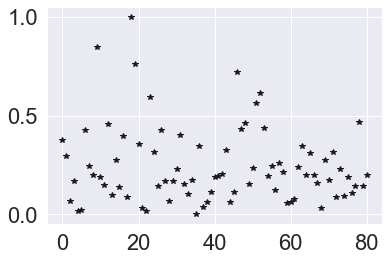

In [58]:
# create cez impulse maps
cez_impulse_maps = create_impulse_maps(impulseresponses, ieegcezinds, onsetwin, offsetwin)

ImpResponse shape, current response shape, l2norm vec shape:  (1298, 81, 81) (81, 81) (81, 1)


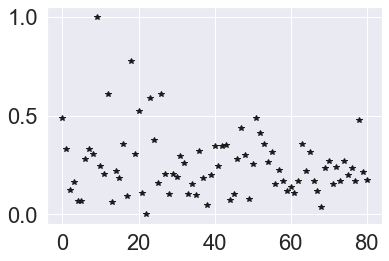

In [59]:
# create oez impulse maps
oez_impulse_maps = create_impulse_maps(impulseresponses, otherinds, onsetwin, offsetwin)

ImpResponse shape, current response shape, l2norm vec shape:  (1298, 81, 81) (81, 81) (81, 1)


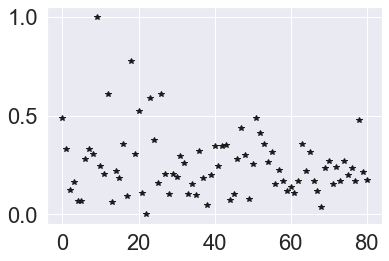

In [60]:
all_impulse_maps = create_impulse_maps(impulseresponses, 
                                       np.arange(len(chanlabels)), 
                                       onsetwin, 
                                       offsetwin)

In [61]:
print(patid)
pprint(list(cez_impulse_maps.keys()))
pprint(oez_impulse_maps.keys())

pt6
['lah1',
 'lah2',
 'lah3',
 'lah4',
 'lph1',
 'lph2',
 'lph3',
 'lph4',
 'la1',
 'la2',
 'la3',
 'la4']
dict_keys(['rft1', 'rft2', 'rft3', 'rft4', 'rft5', 'rft6', 'ralt1', 'ralt2', 'ralt3', 'ralt4', 'rast1', 'rast2', 'rast3', 'rast4', 'rpst1', 'rpst2', 'rpst3', 'rpst4', 'rplt1', 'rplt2', 'rplt3', 'ralt5', 'ralt6', 'rplt4', 'rplt5', 'rplt6', 'rah1', 'rah2', 'rah3', 'rah4', 'rph1', 'rph2', 'rph3', 'rph4', 'ra1', 'ra2', 'ra3', 'ra4', 'rr1', 'lft1', 'lft2', 'lft3', 'lft4', 'lft5', 'lalt1', 'lalt2', 'lalt3', 'lalt4', 'lalt5', 'lalt6', 'last1', 'last2', 'last3', 'last4', 'lpst1', 'lpst2', 'lpst3', 'lpst4', 'lplt2', 'lplt3', 'lplt4', 'lplt5', 'lplt6', 'lpt1', 'lpt2', 'lpt3', 'lpt4', 'lpt5', 'lpt6'])


# Combine Maps For CEZ and OEZ

- statistical combine: average/median 

In [62]:
print(patid)
print(cezcontacts)
print(figdir)

pt6
['la1', 'la2', 'la3', 'la4', 'lah1', 'lah2', 'lah3', 'lah4', 'lph1', 'lph2', 'lph3', 'lph4']
/Users/adam2392/Documents/figures/impulse_responses/pt6


(81, 81, 1298)


../../eztrack/edv/baseplot.py:134: UserWarning: Noninteractive matplotlib backend! No highlighting functionality in plots!
  "Noninteractive matplotlib backend! No highlighting functionality in plots!")


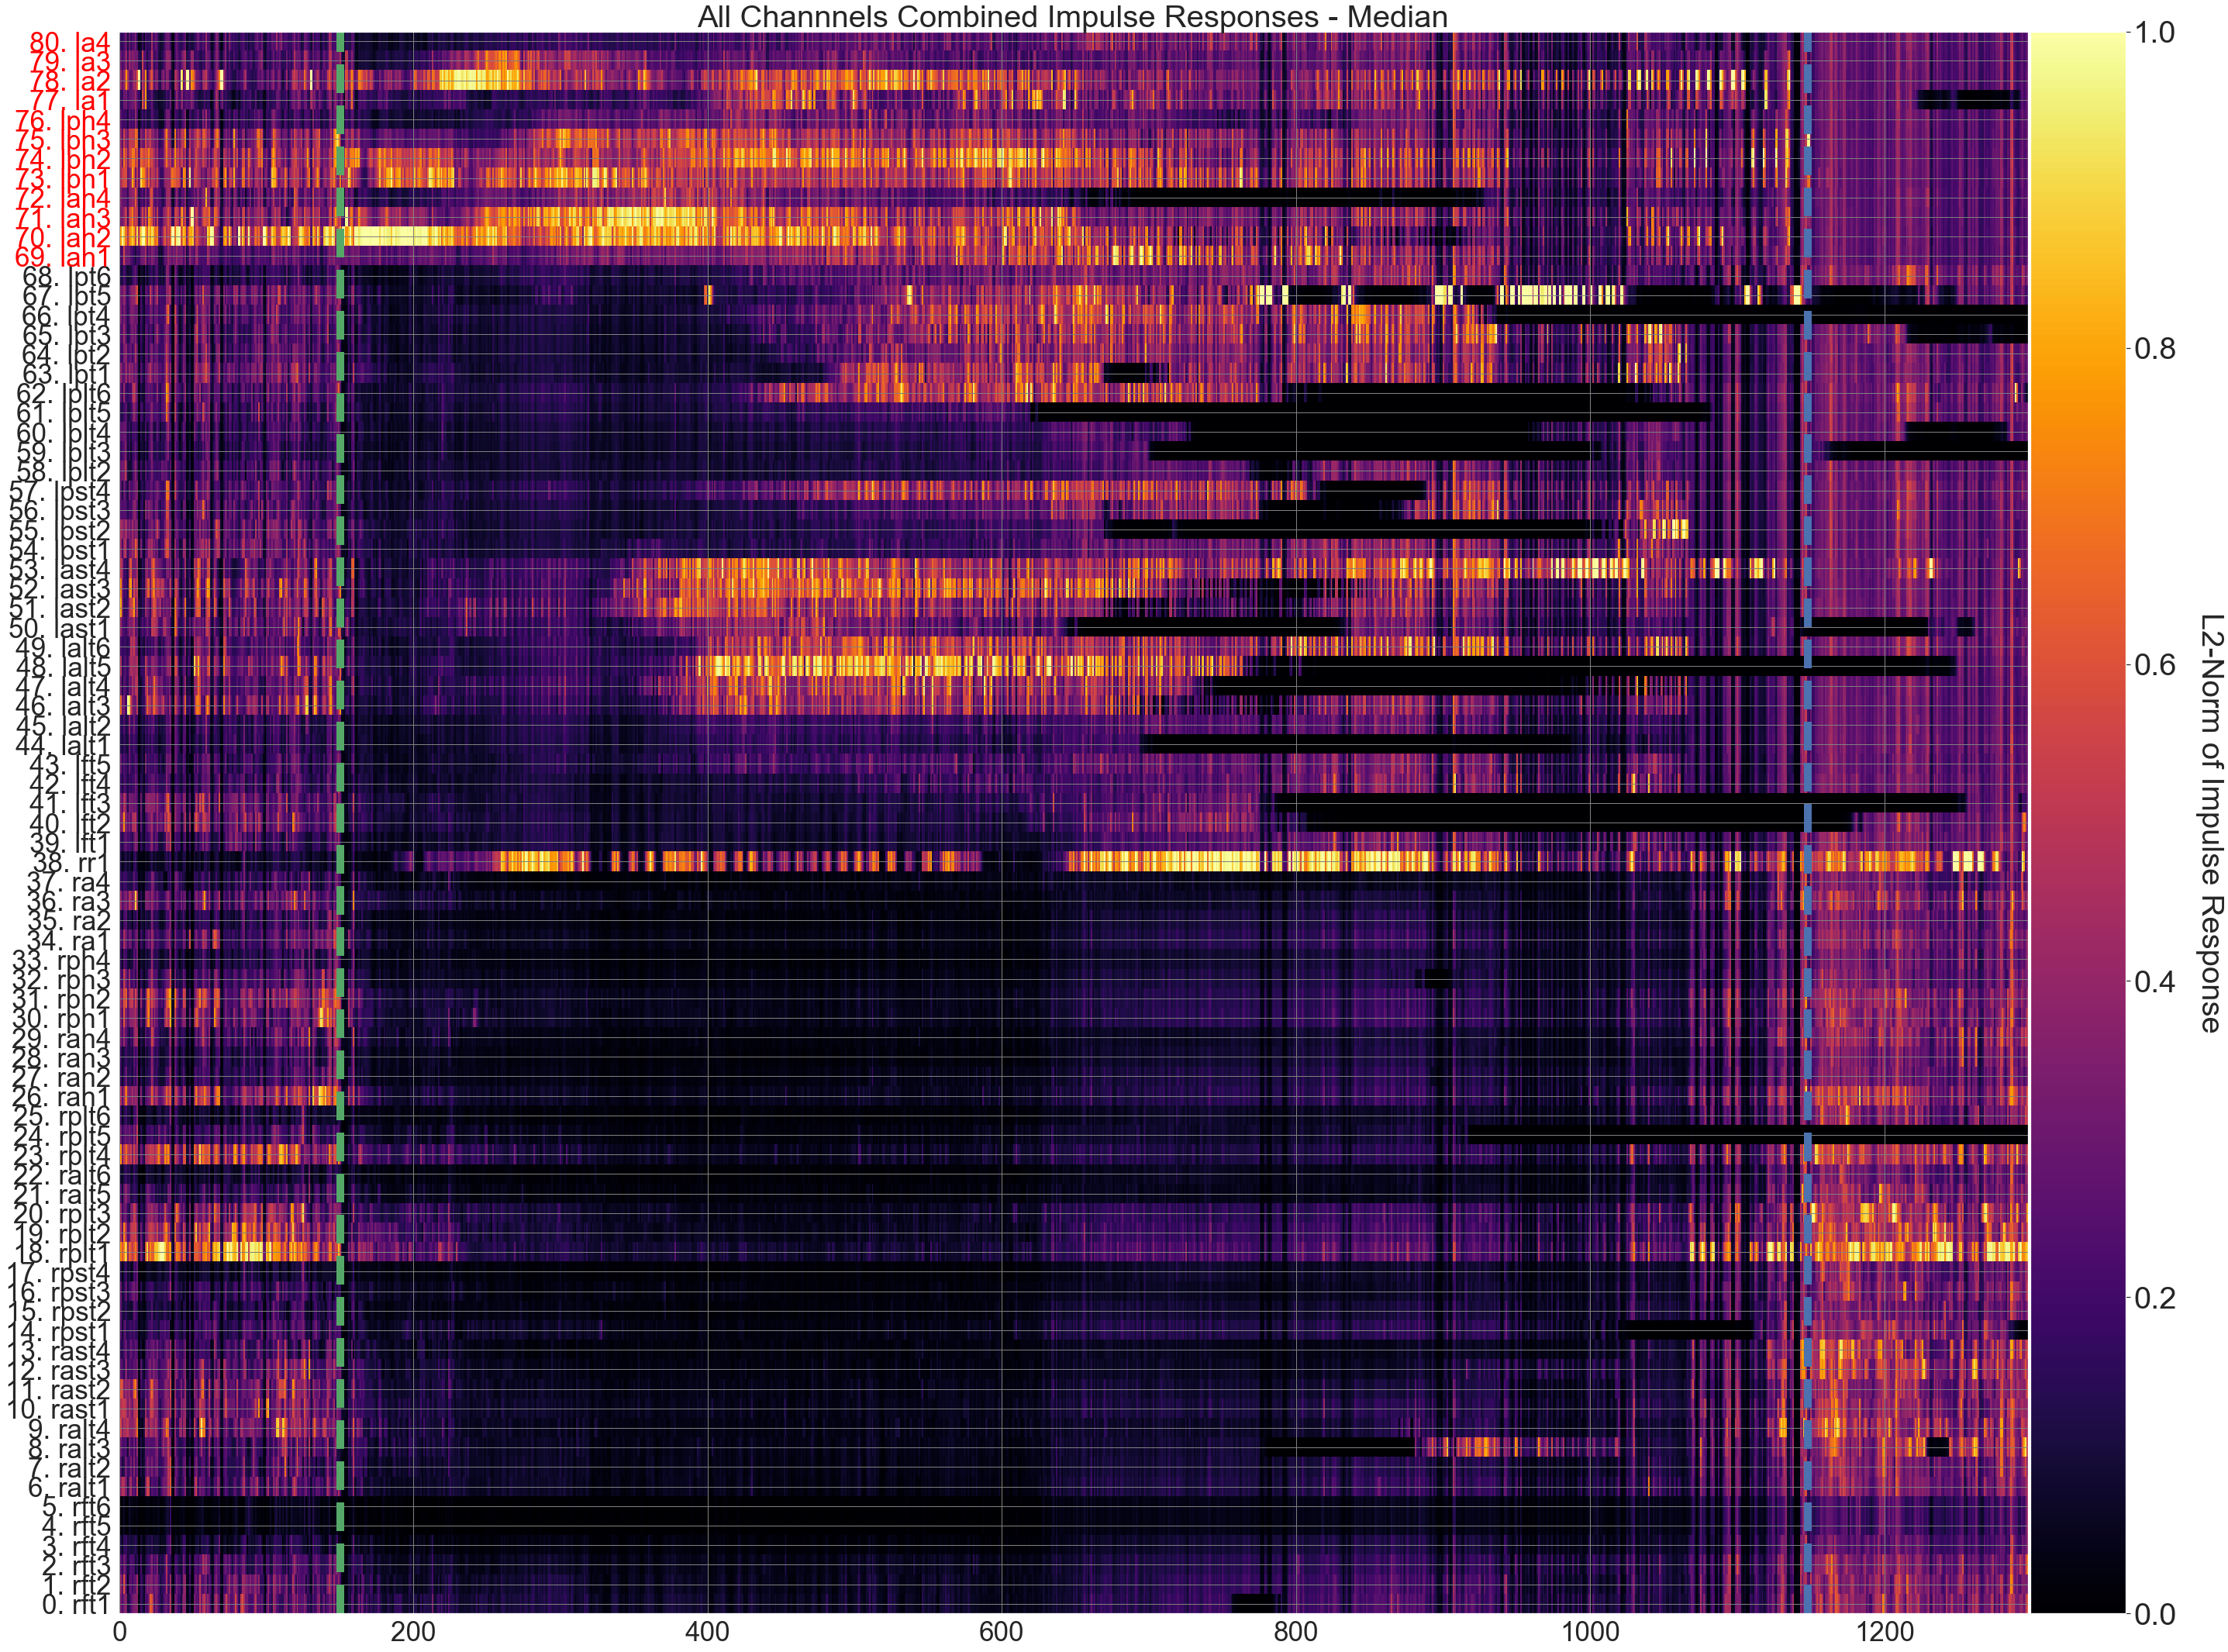

In [63]:
all_map = []

for ind in all_impulse_maps.keys():
    currimpmap = all_impulse_maps[ind]
    all_map.append(currimpmap)
all_map = np.array(all_map)
print(all_map.shape)

# combine
all_map = np.mean(all_map, axis=0)

titlestr = "All Channnels Combined Impulse Responses - Median"
outputfigurepath = "{}_{}_impulse_response.png".format(patid, 
                                                      impulsemodel.dataset_id)

sns.set(font_scale=2.0)
fig, ax = plot_map(all_map, chanlabels, 
                   cezcontacts, newonsetwin, newoffsetwin, 
     figdir, outputfigurepath, titlestr)

fontsize = 70
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize / 2.0)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize / 2.0)

# for im in ax.get_images():
#     im.set_clim(-3,3)

(12, 81, 1298)


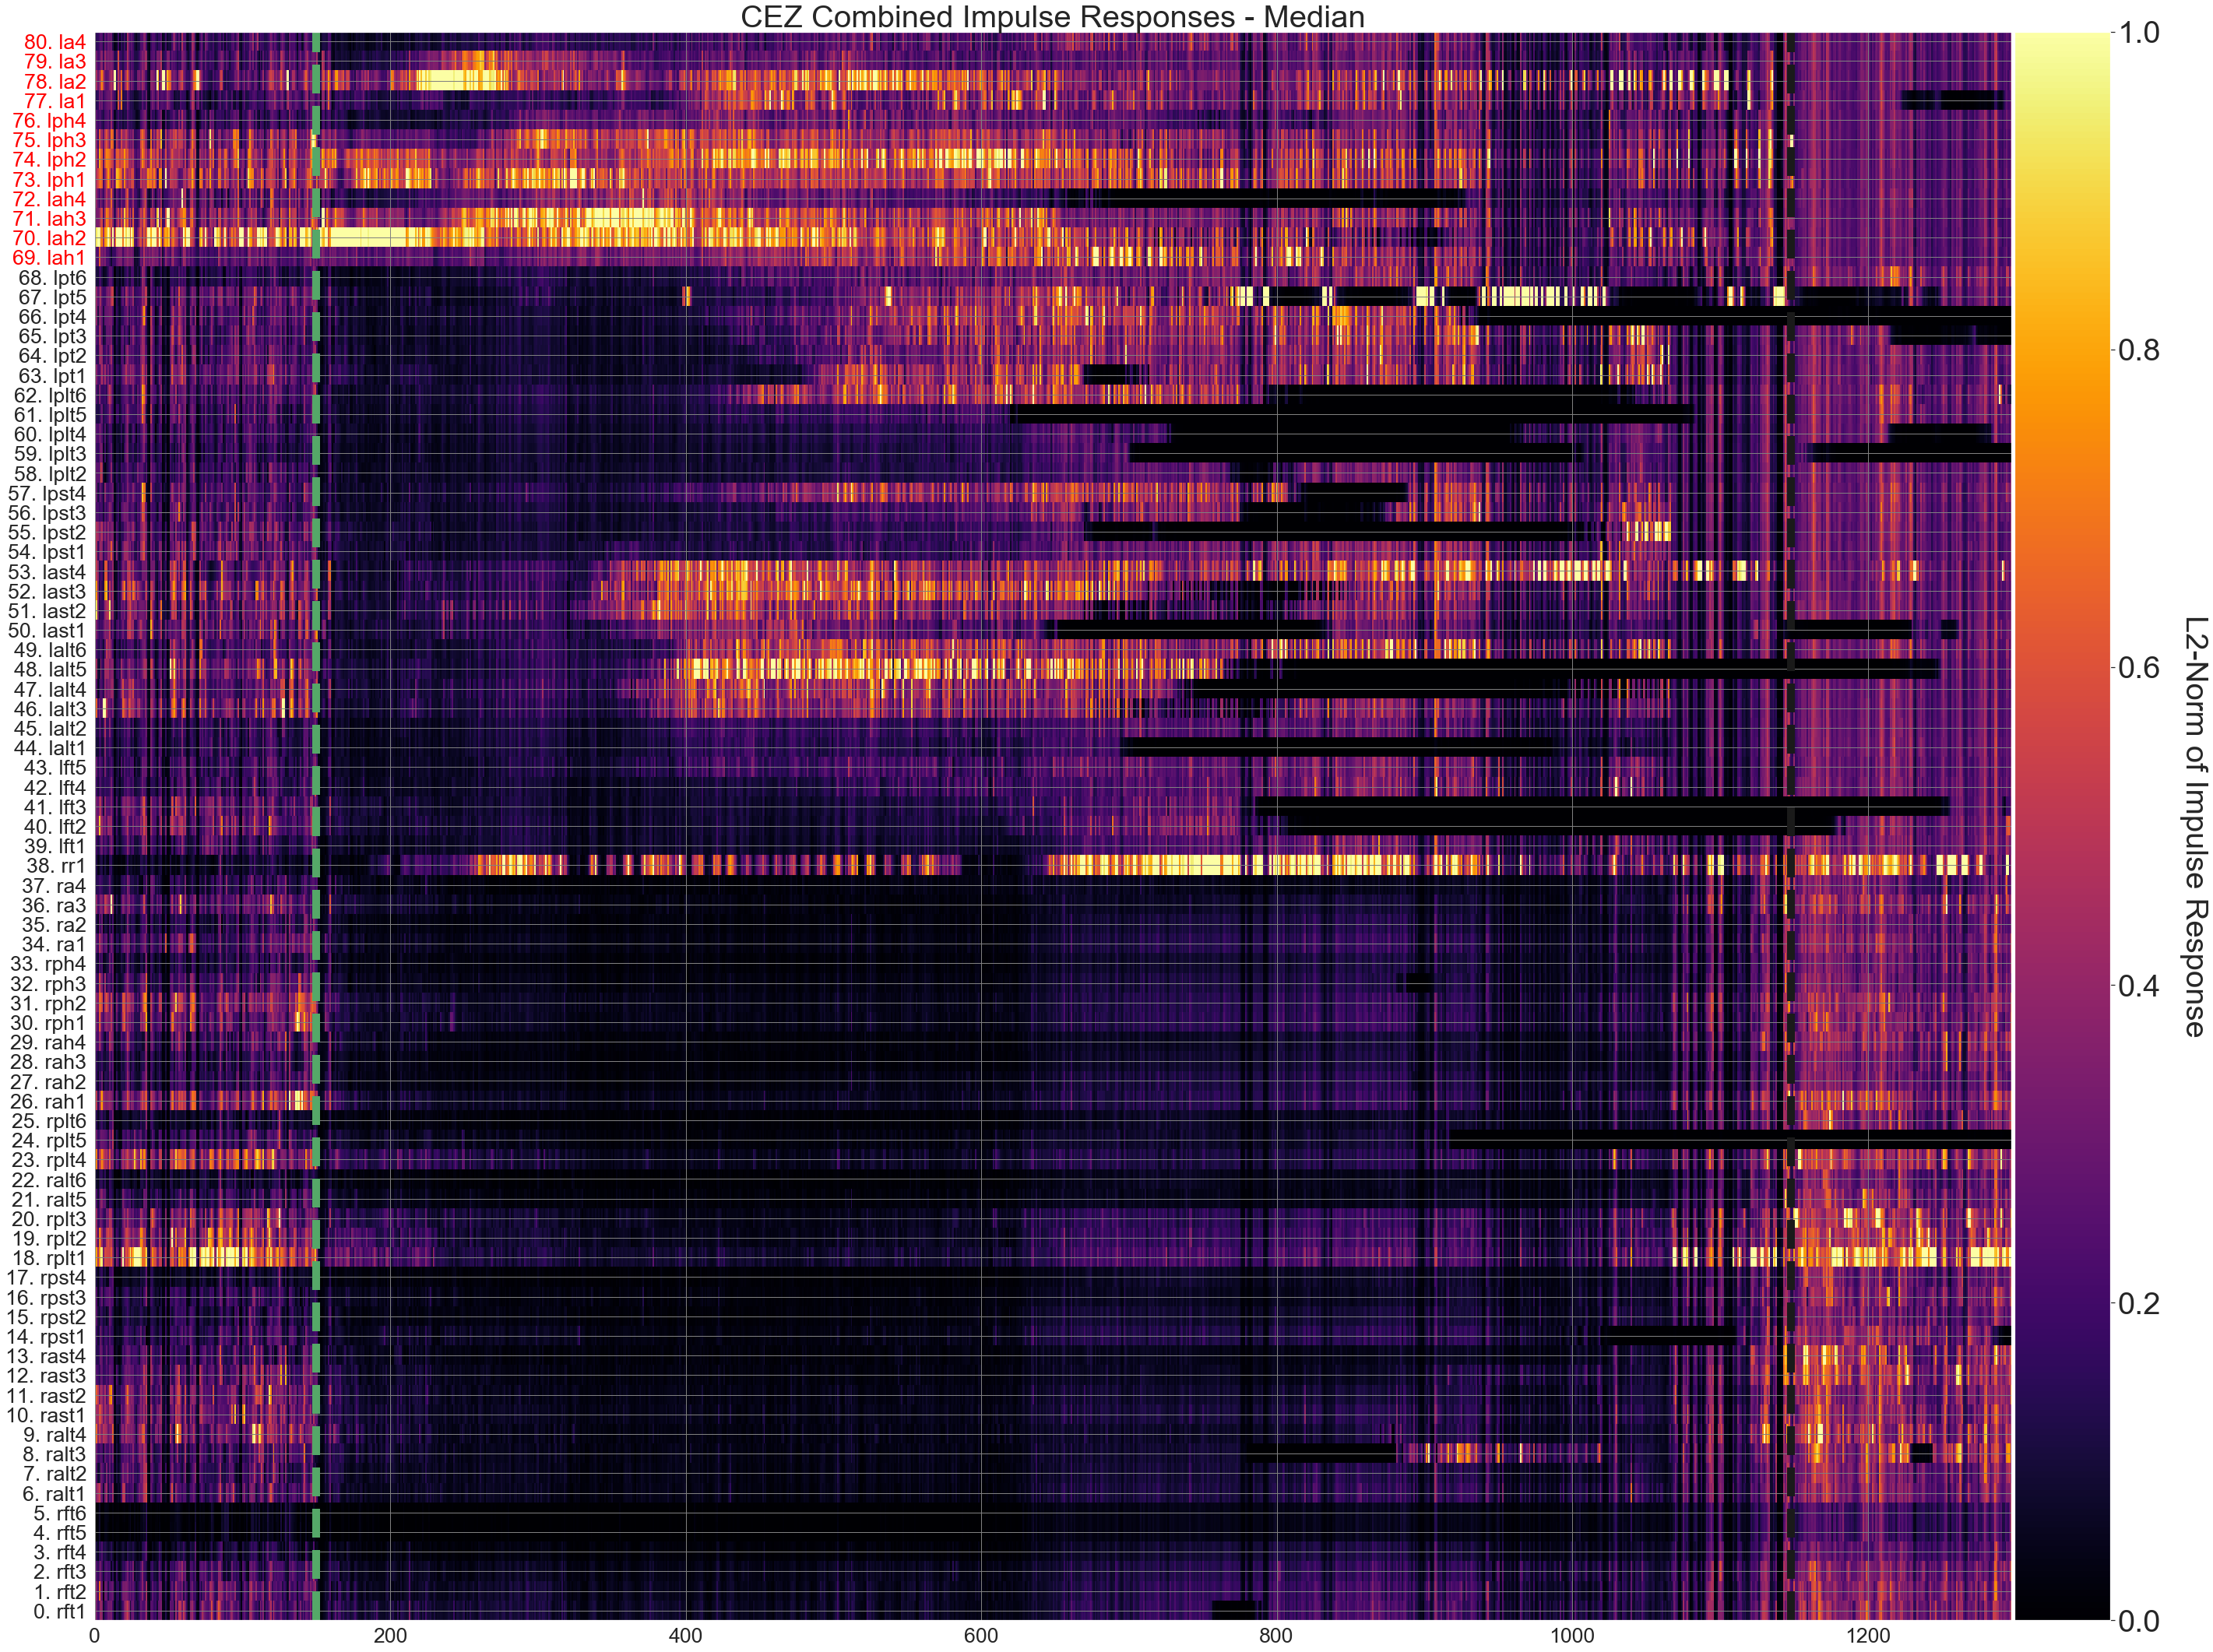

In [32]:
cez_map = []

for cezind in cez_impulse_maps.keys():
    currimpmap = cez_impulse_maps[cezind]
    cez_map.append(currimpmap)
cez_map = np.array(cez_map)
print(cez_map.shape)

# combine
cez_map = np.median(cez_map, axis=0)

titlestr = "CEZ Combined Impulse Responses - Median"
outputfigurepath = "{}_{}_impulse_response.png".format(patid, 
                                                      impulsemodel.dataset_id)
fig, ax = plot_map(cez_map, chanlabels, cezcontacts, newonsetwin, newoffsetwin, 
     figdir, outputfigurepath, titlestr)

# for im in ax.get_images():
#     im.set_clim(-3,3)

(69, 81, 1298)


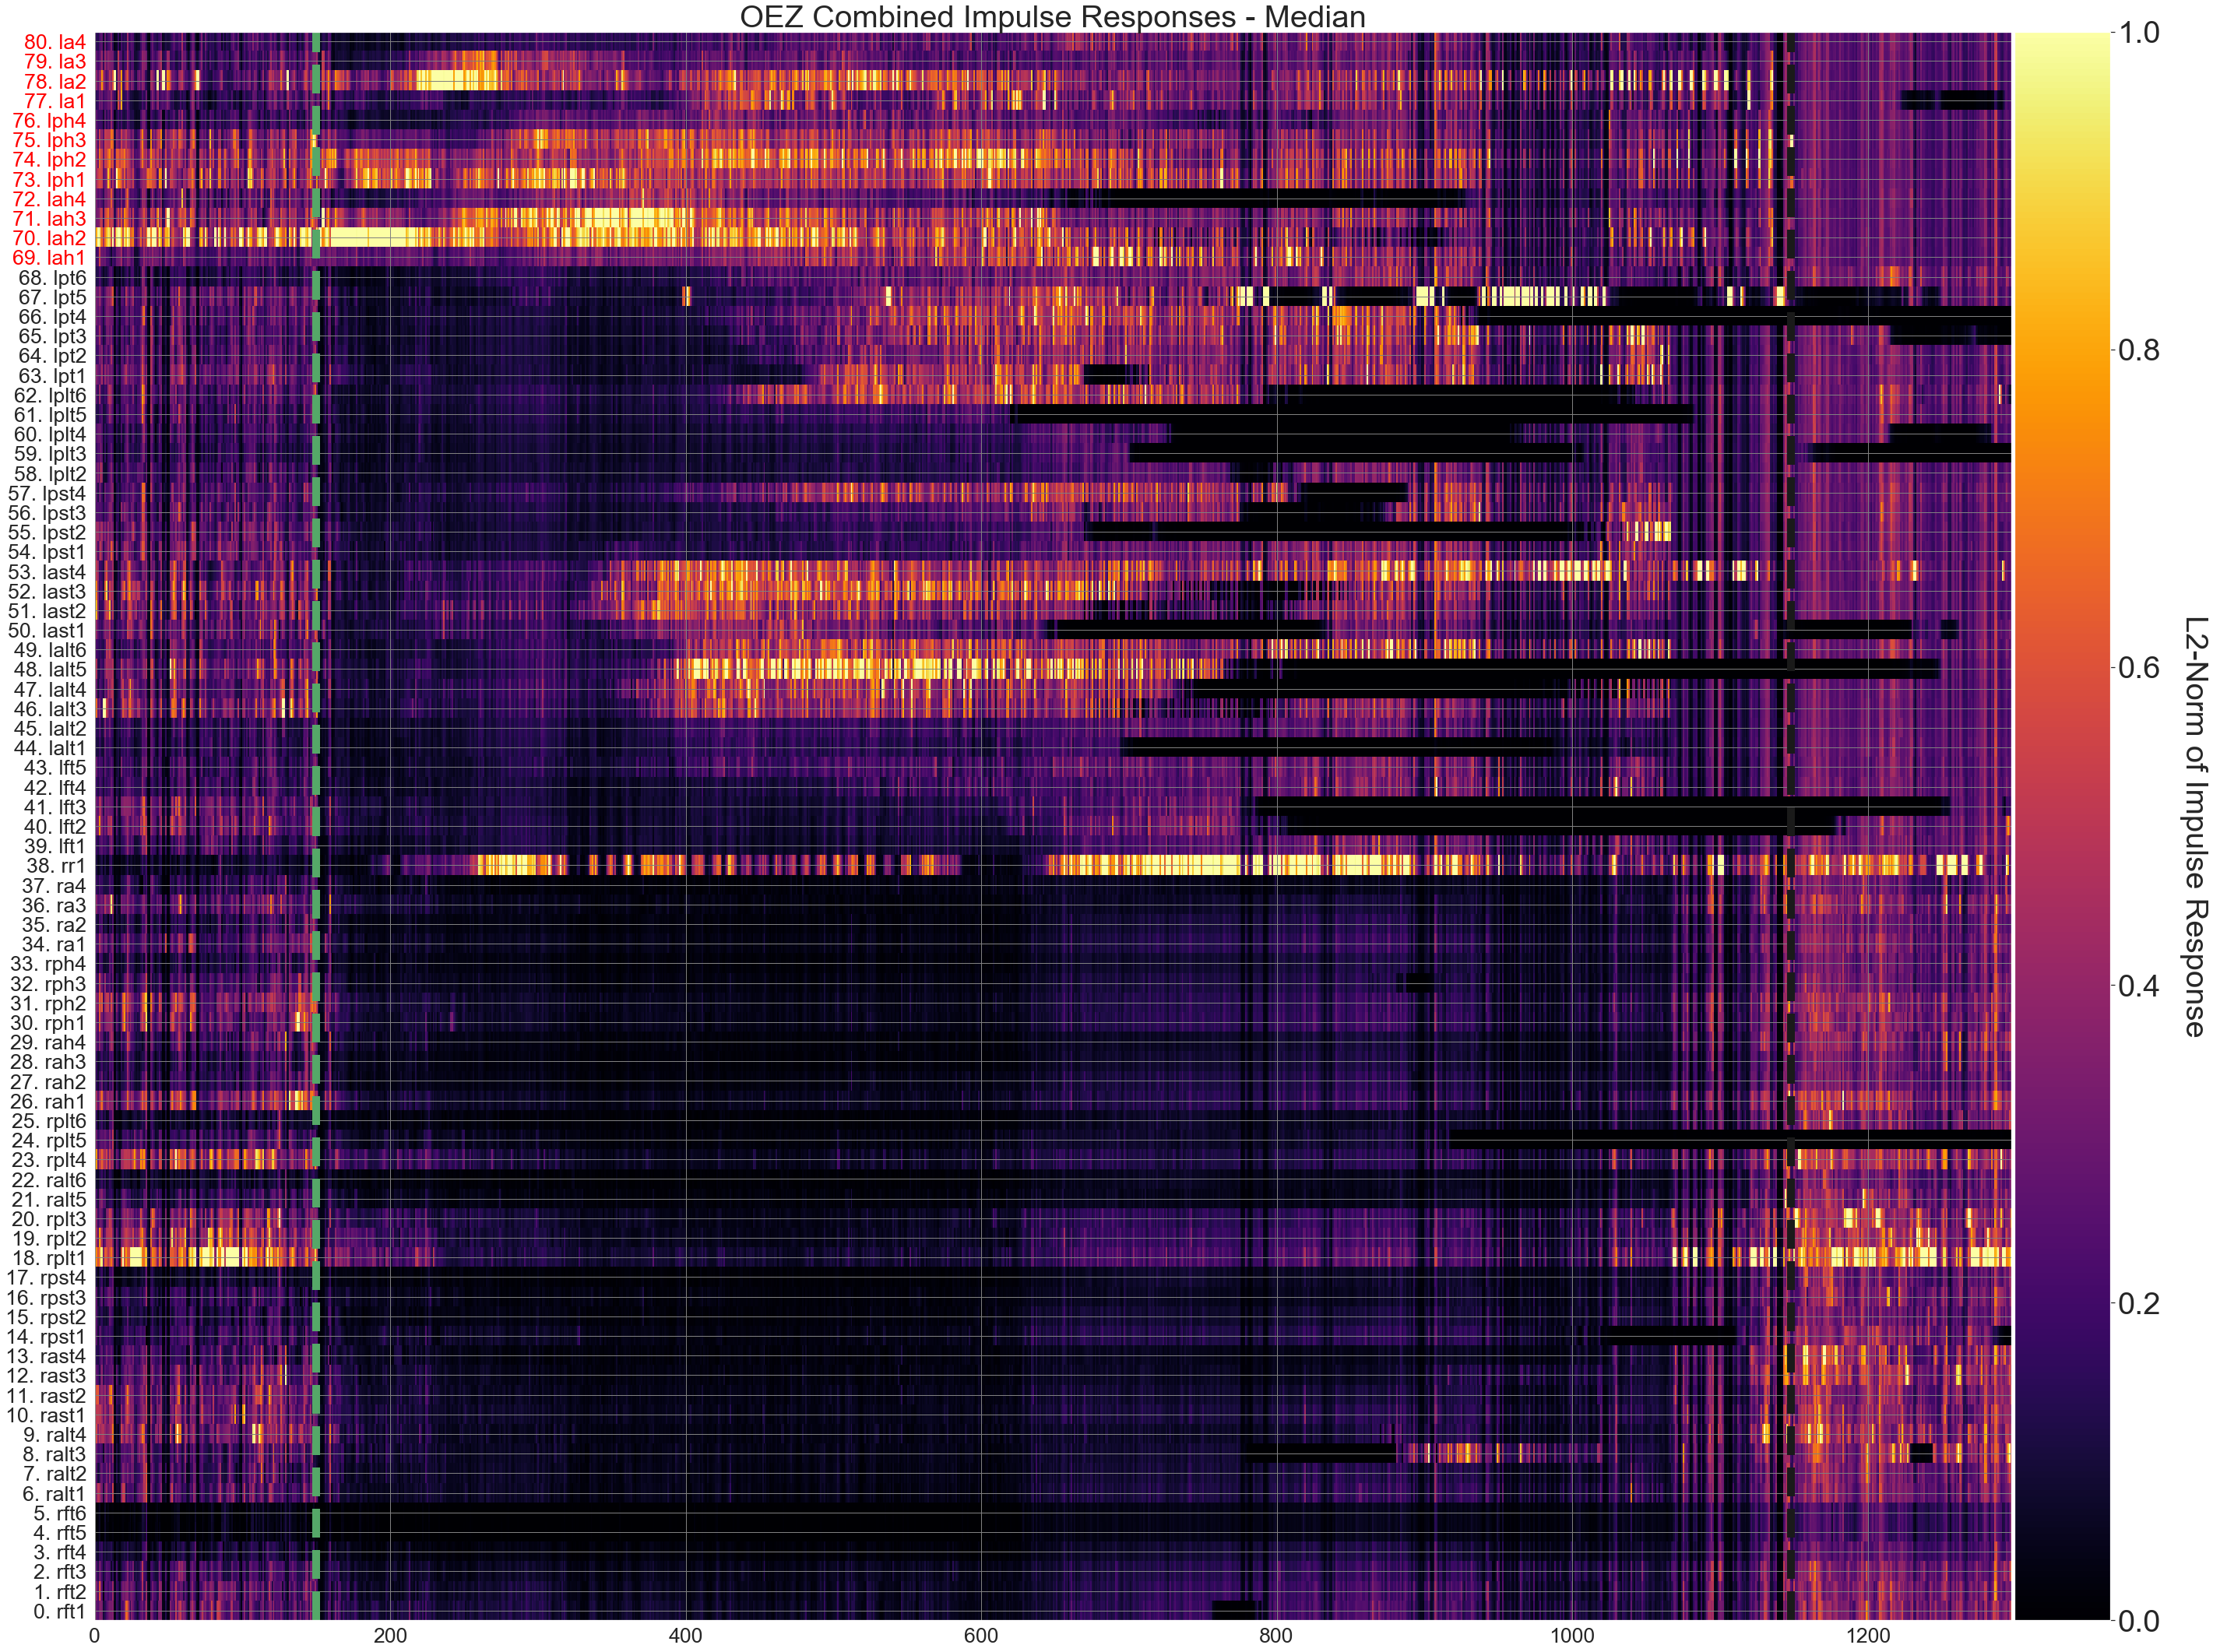

In [33]:
oez_map = []

for oezind in oez_impulse_maps.keys():
    currimpmap = oez_impulse_maps[oezind]
    oez_map.append(currimpmap)
oez_map = np.array(oez_map)
print(oez_map.shape)

# combine
oez_map = np.median(oez_map, axis=0)

titlestr = "OEZ Combined Impulse Responses - Median"
outputfigurepath = "{}_{}_impulse_response.png".format(patid, 
                                                      impulsemodel.dataset_id)
fig, ax = plot_map(oez_map, chanlabels, cezcontacts, newonsetwin, newoffsetwin, 
     figdir, outputfigurepath, titlestr)
# ax.clim([-3,3])

# for im in ax.get_images():
#     im.set_clim(-3,3)
    
    

Text(0.5, 1, 'Difference of CEZ and OEZ Map')

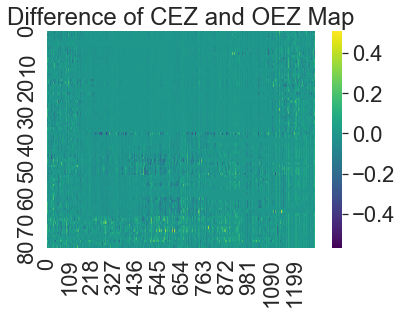

In [35]:
sns.heatmap(cez_map-oez_map, cmap='viridis')
plt.title("Difference of CEZ and OEZ Map")

# Perform CEZ/OEZ Split Analysis on Final Map

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import copy
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix
from edm.classifiers.model.cez_oez_analyzer import FragilitySplitAnalyzer


In [167]:
# create cez oez split
success_pats = ['pt1', 'jh105', 'la02', 'la04']
fail_pats = ['pt6', 'jh108', 'la05']

In [ ]:
# show the difference
fratio_succ = np.nanmean(cezmat_succ, axis=1) / np.nanmean(oezmat_succ, axis=1)
fratio_fail = np.nanmean(cezmat_fail, axis=1) / np.nanmean(oezmat_fail, axis=1)

ytrue = analyzer.outcomelist.copy()
pos_label = 's'
fratio = analyzer.compute_fragilityratio()
ytrue = np.concatenate((np.ones((len(fratio_succ),)), np.zeros((len(fratio_fail),))), axis=0)
fratio = np.concatenate((fratio_succ,fratio_fail))
pos_label = 1

# make box plot
sns.set(font_scale=1.5)
fix, axs = plt.subplots(1,3, figsize=(20,10))
ax = axs[0]
ax.boxplot([fratio_succ, fratio_fail], labels=['succ', 'fail'])
ax.set_title("NIH,CC N={} P={}".format(cezmat.shape[0], 
                                                        analyzer.numpats))
ax.set_ylabel("FR Between CEZ and OEZ")

fpr, tpr, thresholds = roc_curve(ytrue, fratio, pos_label=pos_label)
roc_auc = auc(fpr, tpr)

# make ROC Curve
ax = axs[1]
ax.plot(fpr, tpr, lw=1, 
             label='ROC Curve (AUC = %0.2f)' % (roc_auc))
baselinex = [0, 1-(analyzer.naive_baseline-0.5)]
baseliney = [0+(analyzer.naive_baseline-0.5), 1]
ax.plot(baselinex, baseliney, '--') #
ax.set_ylabel("True Positive")
ax.set_xlabel("False Positive")
ax.set_title("ROC Curve N={} P={}".format(cezmat.shape[0], analyzer.numpats))
ax.legend()


prec, recall, thresholds = precision_recall_curve(ytrue, fratio, pos_label=pos_label)
average_precision = average_precision_score(ytrue, fratio)

# make PR Curve
ax = axs[2]
ax.plot(recall, prec, lw=1, 
             label='PR Curve (AP = %0.2f)' % (average_precision))

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
ax.fill_between(recall, prec, alpha=0.2, color='b', **step_kwargs)

baselinex = [0, 1-(analyzer.naive_baseline-0.5)]
baseliney = [0+(analyzer.naive_baseline-0.5), 1]
ax.plot(baselinex, baseliney, '--') #
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_title("PR-Curve N={} P={}".format(cezmat.shape[0], 
                                                        analyzer.numpats))
ax.legend()


dfdata = []

# get the threshold where 100% gets all the negatives
bestnegind = np.where(fpr>0)[0][0]
thresh_allneg = thresholds[bestnegind]

# define accuracy, sensitivity and specificity
ypred = copy.deepcopy(fratio)
ypred[ypred <= thresh_allneg] = 0
ypred[ypred > thresh_allneg] = 1
ytrue[ytrue=='f'] = 0
ytrue[ytrue == 's'] = 1
ytrue = ytrue.astype(int)
acc = accuracy_score(ytrue, ypred)
tn, fp, fn, tp = confusion_matrix(ytrue, ypred).ravel()
# print(tn, fp, fn, tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print("At 100% Capturing Failures: Acc, sensitivity, specificity", acc, sensitivity, specificity)
# print(bestnegind)
# print(thresh_allneg)

dfdata.append(['Captures All Failures', acc, sensitivity, specificity])

# get all the positives
bestposind = np.where(tpr==1)[0][0]
thresh_allpos = thresholds[bestposind]

# define accuracy, sensitivity and specificity
ypred = copy.deepcopy(fratio)
ypred[ypred <= thresh_allpos] = 0
ypred[ypred > thresh_allpos] = 1
ytrue[ytrue=='f'] = 0
ytrue[ytrue == 's'] = 1
ytrue = ytrue.astype(int)
acc = accuracy_score(ytrue, ypred)
tn, fp, fn, tp = confusion_matrix(ytrue, ypred).ravel()
# print(tn, fp, fn, tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print("At 100% Capturing Successes: Acc, sensitivity, specificity", acc, sensitivity, specificity)

dfdata.append(['Captures All Successes', acc, sensitivity, specificity])

# create dataframe to store this datat
result_df = pd.DataFrame(columns=['Condition', 'Accuracy', 'Sensitivity', 'Specificity'], index=None,
                         data=dfdata)